In [1]:
from zlg import *
from sklearn.linear_model import LogisticRegression
from sklearn.base import clone
import matplotlib.pyplot as plt
import numpy as np
import multiprocessing as mp
from functools import partial


In [2]:
filepath = 'ex2_data.csv'
x, y = ReadExercise2Data(filepath)
print(x.shape, y.shape)
save = True
clf = LogisticRegression()

(673, 8) (673,)


ZLG

In [3]:
n_sims = 10
with mp.Pool(mp.cpu_count()-1) as p:
    args = [(x.copy(), y.copy(),i*2024, clone(clf), ['neg_log_loss'], 0.3, 1.0) for i in range(n_sims)]
    async_res = p.starmap_async(partial(SimulateZLG), args)
    async_res.wait()
    results = async_res.get()

In [4]:
reformated_results = []
for log in results: # 1 logs for each simulation
    tmp = [] # For storing the results of this simulation
    for generation in log: # Each log has n_iters generations of data saved
        tmp.append(generation[0]) # Store the first log metric for this generation
    reformated_results.append(tmp)
reformated_results = np.array(reformated_results)

if save:
    np.save('results/zlg_log_loss.npy',reformated_results)

In [5]:
from active_learning import *

Expected Risk Minimization (Type 1)

In [6]:
n_sims = 10
with mp.Pool(mp.cpu_count()-1) as p:
    args = [(x.copy(), y.copy(),'ERM',i*2024,clone(clf), ['neg_log_loss'], y.copy(), None, 0.3, 1.0, CrossValLog) for i in range(n_sims)]
    async_res = p.starmap_async(partial(SimulateAL_MP), args)
    async_res.wait()
    results = async_res.get()



In [7]:
reformated_results = []
for log in results: # 1 logs for each simulation
    tmp = [] # For storing the results of this simulation
    for generation in log: # Each log has n_iters generations of data saved
        tmp.append(generation[0]) # Store the first log metric for this generation
    reformated_results.append(tmp)
reformated_results = np.array(reformated_results)

if save:
    np.save('results/ERM_log_loss.npy',reformated_results)

Visualization

In [8]:
zlg_results = np.load('results/zlg_log_loss.npy')
erm_results = np.load('results/ERM_log_loss.npy')
print(zlg_results.shape, erm_results.shape)

(10, 473) (10, 473)


In [15]:
def PlotData(filepaths, labels, full_data_size = None):
    fig, ax = plt.subplots(1)
    mse = []
    errors = []
    for path in filepaths:
        data = np.load(f"results/{path}")
        mse.append(-np.mean(data, axis=0))
        errors.append(np.std(data, axis=0))
    
    if full_data_size is None:
        x_pad = 0
    else: 
        x_pad = full_data_size-data.shape[1]
    
    if full_data_size < len(mse):
        raise Exception('full_data_size is shorter than the length of the datasets.')
    
    for data, err, label in zip(mse, errors, labels):
        handle, = ax.plot(range(x_pad, len(data)+x_pad), data, label = label)
        color = handle.get_color()
        ax.errorbar(range(x_pad, len(data)+x_pad), data, err, color = color, linestyle = '', capsize=5, alpha = 0.2)
        ax.legend()

    return fig, ax
    

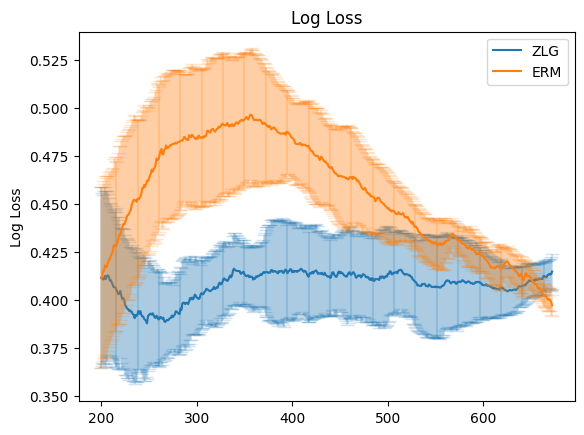

In [16]:
filepaths = ['zlg_log_loss.npy', 'ERM_log_loss.npy']
labels = 'ZLG', 'ERM'
fig, ax = PlotData(filepaths, labels, x.shape[0])
ax.set_title('Log Loss')
ax.set_ylabel('Log Loss')
plt.show(fig)